# Weed & Rose Detection with Ultralytics YOLOv8n
This notebook trains a YOLOv8n model to detect weeds and roses from an annotated dataset of segmentation masks. It defines environment settings, configuration parameters, and the training process — with options for augmentation, reproducibility, and automatic folder management.

# 1. Environment & Versions
This cell verifies that the environment required for training the model is correctly configured. <br>
It separates the upcoming technical configuration from the general project description and imports essential Python libraries such as:
- **PyTorch**, which provides GPU acceleration and the training framework.
- **Albumentations**, a library used for data augmentation.
- **Sys**, **platform**, and **os**, to display system information.

After importing, it prints the versions of Python and PyTorch and checks if **CUDA (GPU)** is available.

**Purpose:**
This ensures that the notebook is running inside the correct **Conda environment** (in this case, the `yolo` environment) and that all necessary dependencies are installed.
It also confirms that GPU acceleration is available — which significantly speeds up model training.


In [1]:
# Make sure the notebook kernel is the conda env: Python (yolo)
import sys, platform, torch, os
import albumentations as A
print("Python:", sys.version)
print("OS:", platform.platform())
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
print("Albumentations version:", A.__version__)

Python: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
OS: Windows-10-10.0.26200-SP0
CUDA available: True
GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Albumentations version: 2.0.8


# 2. Paths & Config

This cell defines all **core paths and training parameters** required for the YOLOv8n model.

### What it does:
1. Imports the necessary libraries:
   - `Path` — for working with directories in a clean, cross-platform way.
   - `yaml` — to neatly display the configuration dictionary in YAML format.
2. Defines the main project directories:
   - `PROJECT_ROOT`: the base folder of the project (`D:/Ai Systems Group`).
   - `DATA_YAML`: the path to the dataset configuration file that contains the `train` and `val` image and label paths.
   - `OUT_DIR`: the directory where YOLO will store all training runs, weights, and results.
3. Creates the `CFG` dictionary that stores **all hyperparameters and file paths** used during training.
4. Performs a quick **sanity check** to make sure the dataset YAML file exists.
5. Prints out the configuration in an easy-to-read YAML format for verification.

---

### Explanation of Key Parameters:
| Parameter | Description |
|------------|-------------|
| `data` | Path to your dataset YAML file that defines training/validation sets. |
| `model` | Base YOLO model to fine-tune — here `yolov8n.pt` (nano version, small and fast). |
| `epochs` | Number of training iterations over the full dataset (here, 100). |
| `batch` | Number of images processed per training step. Increased slightly to 6 for better performance if VRAM allows. |
| `imgsz` | Image size (resolution). Increased to 768 to improve detection of smaller weeds. |
| `workers` | Number of data loader workers (keep low on Windows for stability). |
| `device` | GPU index (0 = first GPU, or `"cpu"` if GPU not available). |
| `project` | Path to the folder where YOLO will create subfolders for each training run. |
| `name` | Base name for the current experiment folder (e.g., `yolov8n-weeds`). |
| `exist_ok` | When set to `False`, YOLO will automatically create incremented folders like `yolov8n-weeds2`, `yolov8n-weeds3`, etc., to prevent overwriting. |
| `plots` | Enables automatic generation of training curve plots such as `results.png`. |
| `patience` | Early stopping patience — number of epochs with no improvement before stopping. |
| `seed` | Random seed for reproducibility of training results. |

---

### Purpose:
This configuration cell ensures that:
- All dataset paths and training hyperparameters are centralized in one place.
- The notebook remains reproducible and easy to modify for future experiments.
- YOLO can automatically organize results without overwriting previous runs.

In [10]:
from pathlib import Path
import yaml

PROJECT_ROOT = Path(r"D:/Ai Systems Group")
DATA_YAML    = PROJECT_ROOT / "data/weeds_yolo_mask/data.yaml"
OUT_DIR      = PROJECT_ROOT / "work_dirs"

CFG = {
    "data": str(DATA_YAML),
    "model": "yolov8n-seg.pt",
    "epochs": 120,
    "batch": 9,
    "imgsz": 1024,
    "workers": 5,
    "device": 0,
    "project": str(OUT_DIR),
    "name": "yolov8n-seg-weeds",
    "exist_ok": False,
    "plots": True,
    "patience": 25,
    "seed": 42,
    # "close_mosaic": 10,
    # "cache": "ram",
}


# 3. Inspect dataset YAML
This cell opens and reads the dataset configuration file (`data.yaml`) to verify that it is correctly defined and accessible.

### What it does:
1. Uses Python’s built-in file handling (`open`) together with the `yaml` library to load the dataset configuration.
2. Reads the contents of the `data.yaml` file, which typically includes:
   - The paths to the **training** and **validation** image directories.
   - A list of **class names** (e.g., `weed`, `rose`).
   - The total number of classes (`nc`).
3. Prints the dictionary (`ds`) so you can visually confirm that all paths and labels are correct before starting training.


In [8]:
with open(DATA_YAML, "r", encoding="utf-8") as f:
    ds = yaml.safe_load(f)
print(ds)


{'path': 'D:/Ai Systems Group/data/weeds_yolo_mask', 'train': 'images/train', 'val': 'images/val', 'names': {0: 'weed', 1: 'rose'}}


# 4. Model Training
This is the main training step of the notebook.
It loads the YOLOv8n model, applies all the training configurations defined earlier (`CFG`), and begins the training process using the specified dataset and augmentations.

---

### What it does
1. **Imports and loads the YOLO model:**
   - `model = YOLO(CFG["model"])` loads the base model architecture (`yolov8n.pt`), which is the lightweight **nano version** of YOLOv8, optimized for speed and smaller datasets.
2. **Trains the model using** `model.train(...)` with all your specified parameters:
   - Dataset path (`data`)
   - Number of epochs
   - Image size and batch size
   - GPU device index
   - Output directory and run name
   - Early stopping settings (`patience`)
   - Random seed for reproducibility
3. **Includes multiple image augmentations** (both built-in YOLO and Albumentations-level options) to improve generalization.
4. **Saves results automatically** in your `OUT_DIR` folder under an experiment name such as:

In [9]:
from ultralytics import YOLO

model = YOLO(CFG["model"])  # loads yolov8n.pt (detection)
results = model.train(
    data=CFG["data"],
    epochs=CFG["epochs"],
    imgsz=CFG["imgsz"],
    batch=CFG["batch"],
    workers=CFG["workers"],
    device=CFG["device"],
    project=CFG["project"],
    name=CFG["name"],
    exist_ok=CFG["exist_ok"],
    patience=CFG["patience"],
    seed=CFG["seed"],
    plots=True,

    # --Augmentations--
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    degrees=5.0, translate=0.1, scale=0.5, shear=2.0,
    perspective=0.0,
    flipud=0.0, fliplr=0.5,
    mosaic=0.5,
    mixup=0.1,
    close_mosaic=10
)
results


New https://pypi.org/project/ultralytics/8.3.225 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.220  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=9, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\Ai Systems Group\data\weeds_yolo_mask\data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=0.5, multi_scal

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001D2308B44C0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0

# View training curves

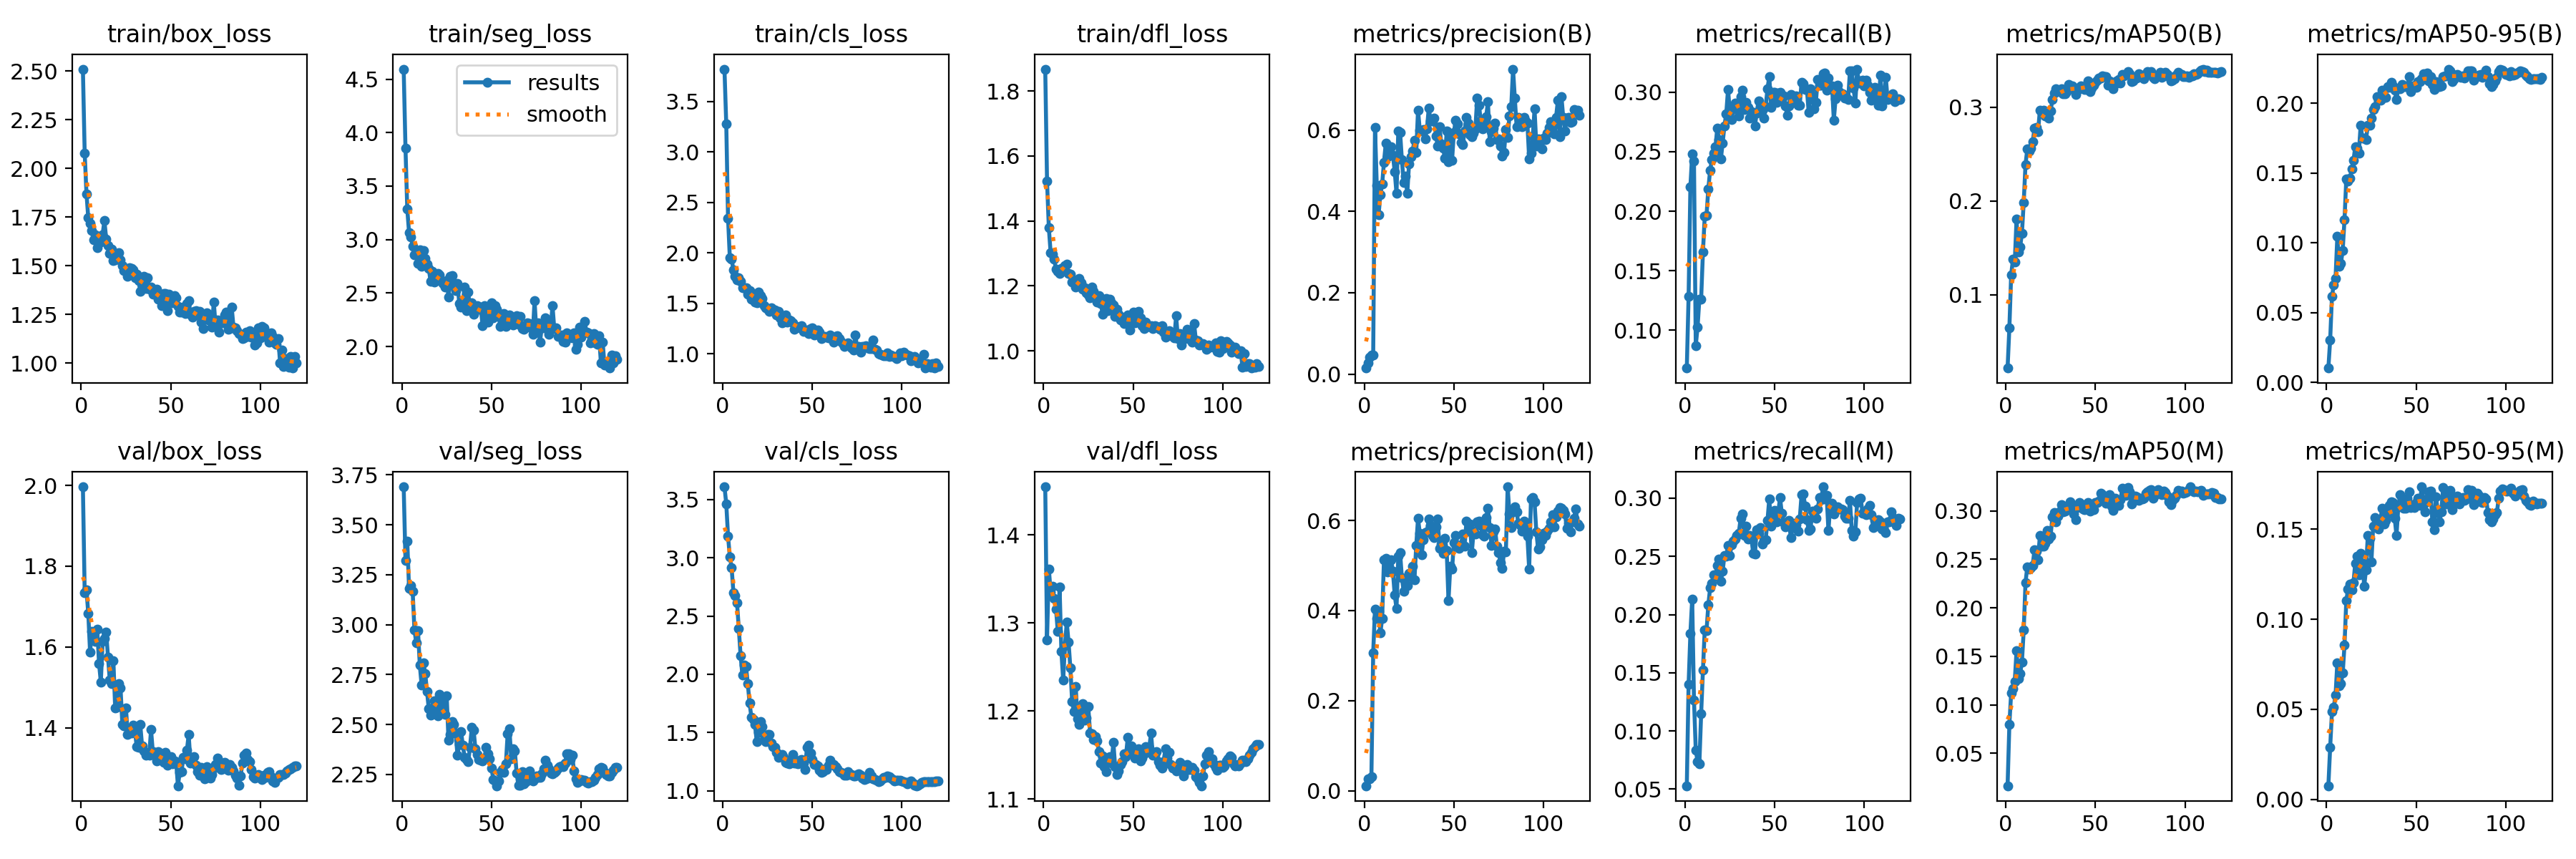

In [12]:
from IPython.display import display
from PIL import Image

run_dir = OUT_DIR / "yolov8n-seg-weeds"
img = run_dir / "results.png"
if img.exists():
    display(Image.open(img))
else:
    print("results.png not found yet:", img)


# Validate on val set (metrics + plots)

In [13]:
metrics = model.val(
    data=CFG["data"],
    project=str(OUT_DIR),
    name=f"{CFG['name']}-val",
    plots=True
)
metrics


Ultralytics 8.3.220  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,454 parameters, 0 gradients, 11.3 GFLOPs
val: Fast image access  (ping: 0.40.1 ms, read: 1566.7788.5 MB/s, size: 5282.4 KB)
val: Scanning D:\Ai Systems Group\data\weeds_yolo_mask\labels\val.cache... 21 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 21/21  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 0.5it/s 3.8s10.4s
                   all         21       1428      0.572      0.309      0.334      0.225      0.545      0.297      0.321      0.169
                  weed         21        570      0.617      0.519      0.567      0.396      0.631      0.512      0.558      0.311
                  rose         21        858      0.528     0.0979      0.102     0.0541      0.459     0.0816     0.0833     0.0281
Speed

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001D18B5D5B40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004

# Predict on some images

In [14]:
VAL_IMAGES = Path(ds["path"]) / ds["val"]  # images/val folder
pred = model.predict(
    source=str(VAL_IMAGES),
    project=str(OUT_DIR),
    name=f"{CFG['name']}-pred",
    save=True,      # save images with drawn boxes
    save_txt=True,  # save YOLO txt predictions
    conf=0.25       # tweak for precision/recall trade-off
)
pred[:2]



image 1/21 D:\Ai Systems Group\data\weeds_yolo_mask\images\val\DJI_0193.JPG: 576x1024 13 weeds, 4 roses, 100.4ms
image 2/21 D:\Ai Systems Group\data\weeds_yolo_mask\images\val\DJI_0194.JPG: 576x1024 11 weeds, 4 roses, 12.7ms
image 3/21 D:\Ai Systems Group\data\weeds_yolo_mask\images\val\DJI_0201.JPG: 576x1024 19 weeds, 8 roses, 13.8ms
image 4/21 D:\Ai Systems Group\data\weeds_yolo_mask\images\val\DJI_0203.JPG: 576x1024 47 weeds, 7 roses, 285.9ms
image 5/21 D:\Ai Systems Group\data\weeds_yolo_mask\images\val\DJI_0204.JPG: 576x1024 38 weeds, 10 roses, 227.6ms
image 6/21 D:\Ai Systems Group\data\weeds_yolo_mask\images\val\DJI_0207.JPG: 576x1024 26 weeds, 9 roses, 233.6ms
image 7/21 D:\Ai Systems Group\data\weeds_yolo_mask\images\val\DJI_0215.JPG: 576x1024 45 weeds, 9 roses, 135.6ms
image 8/21 D:\Ai Systems Group\data\weeds_yolo_mask\images\val\DJI_0217.JPG: 576x1024 39 weeds, 9 roses, 397.1ms
image 9/21 D:\Ai Systems Group\data\weeds_yolo_mask\images\val\DJI_0218.JPG: 576x1024 29 weeds, 

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: 'weed', 1: 'rose'}
 obb: None
 orig_img: array([[[110, 112, 122],
         [ 88,  90, 100],
         [ 87,  89, 100],
         ...,
         [104, 105, 115],
         [105, 107, 117],
         [108, 110, 120]],
 
        [[115, 117, 127],
         [ 91,  93, 103],
         [ 89,  91, 101],
         ...,
         [ 96,  97, 107],
         [ 98, 100, 110],
         [103, 105, 115]],
 
        [[119, 121, 131],
         [ 95,  97, 107],
         [ 89,  91, 101],
         ...,
         [107, 108, 118],
         [106, 108, 118],
         [100, 102, 112]],
 
        ...,
 
        [[140, 143, 148],
         [136, 139, 144],
         [136, 138, 146],
         ...,
         [128, 131, 139],
         [126, 129, 137],
         [134, 137, 145]],
 
        [[144, 142, 148],
         [140, 138, 144],
         [136,

# Visualize predictions
If you want to visualize the predictions that the model did, you can find them in the `work_dir` folder, in the folder that has the extension `-pred` at the end of the name.